- [Import Libraries](#1)
- [Reading the Dataset](#2)
- [Data Pre-processing](#3)
- [Modeling](#4)
    1. [Simple CNN](#8)
    2. [Transform learning with MobileNetV2](#9)
- [Conclusions](#5)
- [Gradio ](#6)
- [References](#7)

# Import Libraries <a id = "1"></a> 

In [2]:
!pip install -q gradio

     |████████████████████████████████| 2.9 MB 5.1 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 211 kB 55.0 MB/s 
     |████████████████████████████████| 253 kB 50.4 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 1.1 MB 56.7 MB/s 
     |████████████████████████████████| 84 kB 4.1 MB/s 
     |████████████████████████████████| 2.0 MB 58.3 MB/s 
     |████████████████████████████████| 144 kB 55.4 MB/s 
     |████████████████████████████████| 271 kB 75.7 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 58 kB 7.9 MB/s 
     |████████████████████████████████| 10.9 MB 59.9 MB/s 
     |████████████████████████████████| 79 kB 9.3 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 61 kB 608 kB/s 
     |████████████████████████████████| 3.6 MB 59.4 MB/s 
     |████████████████████████

In [3]:
import gradio as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.applications.mobilenet_v2 import preprocess_input, MobileNetV2
from keras.layers import BatchNormalization, Conv2D, Dense,Dropout, Flatten, GlobalAveragePooling2D, MaxPool2D, RandomFlip, RandomRotation, ReLU, Rescaling

import warnings
warnings.filterwarnings("ignore")

# Reading the Dataset <a id = "2"></a> 

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


<a href = 'https://www.cs.toronto.edu/~kriz/cifar.html'>Link to CIFAR dataset.</a>

<i>"The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>
The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class."</i>

In [5]:
print(f'Shape of training data: {x_train.shape}')
print(f'Shape of training labels: {y_train.shape}')
print(f'Number of training samples: {x_train.shape[0]}')
print(15 * '-')
print(f'Shape of testing data: {x_test.shape}')
print(f'Shape of testing labels: {y_test.shape}')
print(f'Number of testing samples: {x_test.shape[0]}')
print(15 * '-')
print(f'Size of images: {x_train.shape[1:4]}')

Shape of training data: (50000, 32, 32, 3)
Shape of training labels: (50000, 1)
Number of training samples: 50000
---------------
Shape of testing data: (10000, 32, 32, 3)
Shape of testing labels: (10000, 1)
Number of testing samples: 10000
---------------
Size of images: (32, 32, 3)


# Data Pre-processing <a id = "3"></a> 

Text(0.5, 0, 'Index of each class')

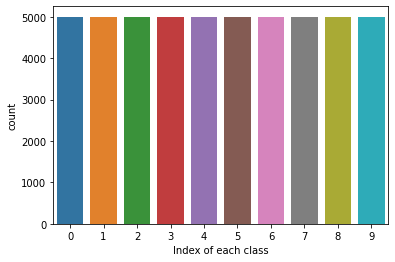

In [6]:
sns.countplot(np.squeeze(y_train))
plt.xlabel('Index of each class')

In [7]:
index_to_name = {0:'Airplane', 1:'Car', 2:'Bird',
                 3:'Cat', 4:'Deer', 5:'Dog',
                 6:'Frog', 7:'Horse', 8:'Ship',
                 9:'Truck'}

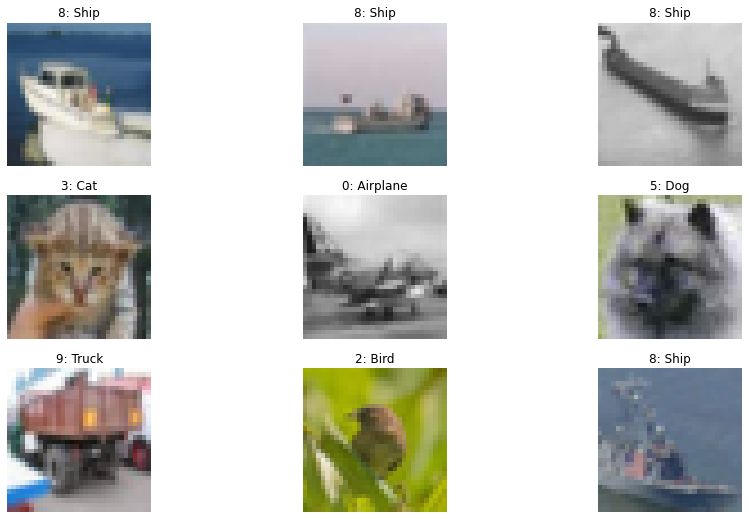

In [8]:
plt.figure(figsize = (15, 9))
for num, i in enumerate(np.random.randint(x_train.shape[0],size = 9)):
    plt.subplot(3,3, num + 1)
    plt.imshow(x_train[i])
    class_index = np.squeeze(y_train[i][0]).astype(int)
    plt.title(f'{class_index}: {index_to_name[class_index]}')
    plt.axis('off')

# Modeling <a id = "4"></a> 


## Simple CNN <a id = "8"></a> 

In [9]:
def make_base_model():
    inputs = keras.Input(shape = (32, 32, 3)) 
    x = Rescaling(1. / 255)(inputs)
    x = RandomFlip()(x)
    x = RandomRotation(0.2, fill_mode = 'nearest')(x)
    x = Conv2D(filters = 8, kernel_size =  2, strides = 2)(x)
    x = ReLU()(x)
    x = BatchNormalization(axis = -1)(x)
    x = MaxPool2D(pool_size = 2, strides = 2)(x)
    x = ReLU()(x)
    x = Conv2D(filters = 16, kernel_size =  2, strides = 2, padding = 'same')(x)
    x = ReLU()(x)
    x = BatchNormalization(axis = -1)(x)
    x = MaxPool2D(pool_size = 4, strides = 4)(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(10, activation = 'softmax')(x)
    model = keras.Model(inputs = inputs, outputs = outputs, name = 'base_model')
    
    return model   

base_model = make_base_model()
base_model.summary()

Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 random_flip (RandomFlip)    (None, 32, 32, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 32, 32, 3)        0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 8)         104       
                                                                 
 re_lu (ReLU)                (None, 16, 16, 8)         0         
                                                        

In [10]:
base_model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath = 'best_base_model.keras',
    save_best_only = True,
    monitor = 'val_accuracy')
]

epochs = 20

history = base_model.fit(
    x_train,
    y_train,
    batch_size = 32,
    epochs = epochs,
    shuffle = True,
    validation_split= 0.2,
    callbacks = callbacks
)

Epoch 1/20
1250/1250 [==============================] - 19s 5ms/step - loss: 2.3516 - accuracy: 0.1729 - val_loss: 2.1057 - val_accuracy: 0.2077
Epoch 2/20
1250/1250 [==============================] - 5s 4ms/step - loss: 2.0513 - accuracy: 0.2331 - val_loss: 1.9933 - val_accuracy: 0.2520
Epoch 3/20
1250/1250 [==============================] - 5s 4ms/step - loss: 1.9893 - accuracy: 0.2562 - val_loss: 2.0510 - val_accuracy: 0.2442
Epoch 4/20
1250/1250 [==============================] - 5s 4ms/step - loss: 1.9530 - accuracy: 0.2714 - val_loss: 1.9812 - val_accuracy: 0.2727
Epoch 5/20
1250/1250 [==============================] - 5s 4ms/step - loss: 1.9283 - accuracy: 0.2830 - val_loss: 1.9494 - val_accuracy: 0.2612
Epoch 6/20
1250/1250 [==============================] - 5s 4ms/step - loss: 1.9134 - accuracy: 0.2902 - val_loss: 1.9013 - val_accuracy: 0.3067
Epoch 7/20
1250/1250 [==============================] - 5s 4ms/step - loss: 1.9004 - accuracy: 0.2963 - val_loss: 1.8862 - val_accuracy

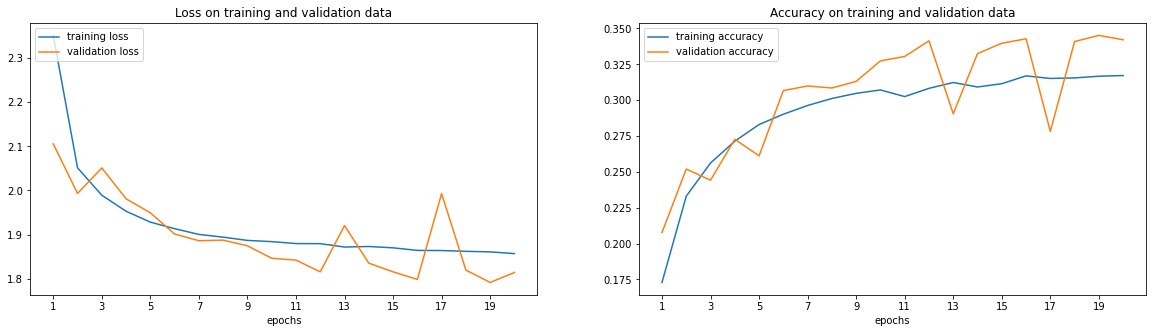

In [11]:
def plot_history(history_of_model):
    plt.figure(figsize = (20, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('Loss on training and validation data')
    sns.lineplot(x = range(1, epochs + 1), y = history_of_model.history['loss'])
    sns.lineplot(x = range(1, epochs + 1), y = history_of_model.history['val_loss'])
    plt.xlabel('epochs')
    plt.xticks(list(range(1, epochs + 1))[::2])
    plt.legend(['training loss', 'validation loss'], loc = 'upper left')
    
    plt.subplot(1, 2, 2)
    plt.title('Accuracy on training and validation data')
    sns.lineplot(x = range(1, epochs + 1), y = history_of_model.history['accuracy'])
    sns.lineplot(x = range(1, epochs + 1), y = history_of_model.history['val_accuracy'])
    plt.xlabel('epochs')
    plt.xticks(list(range(1, epochs + 1))[::2])
    plt.legend(['training accuracy', 'validation accuracy'], loc = 'upper left')
    
    plt.show() 
    
plot_history(history)    

In [12]:
best_base_model = keras.models.load_model('best_base_model.keras')
test_loss, test_acc = best_base_model.evaluate(x_test, y_test)
print(f'Accuracy on testing data with a simple CNN model: {test_acc:0.2%}')

313/313 [==============================] - 1s 2ms/step - loss: 1.7826 - accuracy: 0.3545
Accuracy on testing data with a simple CNN model: 35.45%


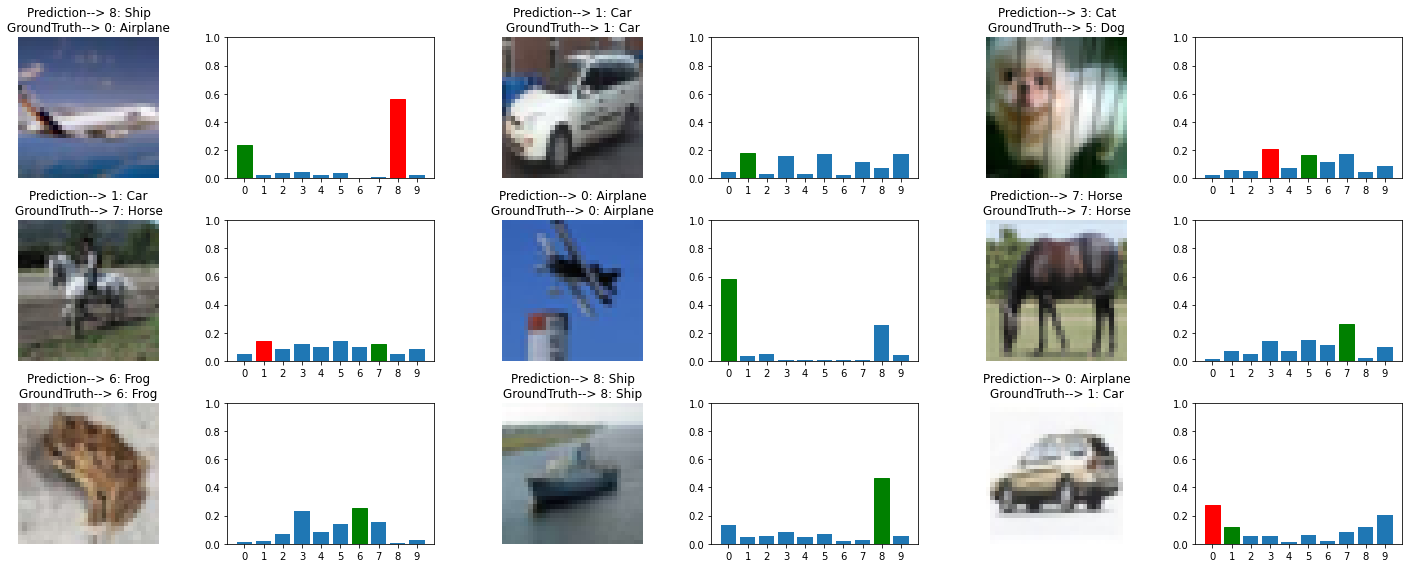

In [13]:
def plot_prob_pred(model, x):

    plt.figure(figsize = (20, 8))
    
    m = x_test.shape[0]
    
    for num, i in enumerate(np.random.randint(m, size = 9)):
            
        pred_prob = model.predict(x[i][np.newaxis, ...])
        pred_class = np.argmax(pred_prob).astype(int)

        plt.subplot(3,6, 2 * num + 1)
        plt.imshow(x_test[i])
        plt.title(f'Prediction--> {pred_class}: {index_to_name[pred_class]}\nGroundTruth--> {y_test[i][0]}: {index_to_name[y_test[i][0]]}')
        plt.axis('off')

        plt.subplot(3,6, 2 * num + 2)
        bar_plot = plt.bar(x = range(10), height = list(np.squeeze(pred_prob)))
        bar_plot[pred_class].set_color('red')
        bar_plot[y_test[i][0]].set_color('green')
        plt.xticks(range(10))
        plt.ylim([0, 1])
    
    plt.tight_layout()

plot_prob_pred(best_base_model, x_test)

## Transform learning with MobileNetV2 <a id = "9"></a> 

In [14]:
base_mobilenet = MobileNetV2(input_shape = (32, 32, 3), weights = 'imagenet', include_top = False)

x_train_pr = preprocess_input(x_train)
x_test_pr = preprocess_input(x_test)

9420800/9406464 [==============================] - 0s 0us/step


In [15]:
x = base_mobilenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation = 'softmax')(x)
x = Dropout(0.5)(x)
output_mobilenet = Dense(10, activation = 'softmax')(x)

mobilenetv2 = keras.Model(inputs = base_mobilenet.inputs, outputs = output_mobilenet, name = 'base_mobilenet_model')

mobilenetv2.summary()

Model: "base_mobilenet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 16, 16, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 16, 16, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 16, 16, 32)   0           ['bn_Conv1[0][0]']               
                                                                               

In [16]:
for i, layer in enumerate(mobilenetv2.layers):
    print(f'Layer number {i}: {layer.name}')

Layer number 0: input_2
Layer number 1: Conv1
Layer number 2: bn_Conv1
Layer number 3: Conv1_relu
Layer number 4: expanded_conv_depthwise
Layer number 5: expanded_conv_depthwise_BN
Layer number 6: expanded_conv_depthwise_relu
Layer number 7: expanded_conv_project
Layer number 8: expanded_conv_project_BN
Layer number 9: block_1_expand
Layer number 10: block_1_expand_BN
Layer number 11: block_1_expand_relu
Layer number 12: block_1_pad
Layer number 13: block_1_depthwise
Layer number 14: block_1_depthwise_BN
Layer number 15: block_1_depthwise_relu
Layer number 16: block_1_project
Layer number 17: block_1_project_BN
Layer number 18: block_2_expand
Layer number 19: block_2_expand_BN
Layer number 20: block_2_expand_relu
Layer number 21: block_2_depthwise
Layer number 22: block_2_depthwise_BN
Layer number 23: block_2_depthwise_relu
Layer number 24: block_2_project
Layer number 25: block_2_project_BN
Layer number 26: block_2_add
Layer number 27: block_3_expand
Layer number 28: block_3_expand_BN

In [17]:
for layer in mobilenetv2.layers[:134]:
    layer.trainable = False
    
for layer in mobilenetv2.layers[134:]:
    layer.trainable = True

In [18]:
mobilenetv2.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

callbacks_mobilenet = [
    keras.callbacks.ModelCheckpoint(
    filepath = 'best_mobilenet_model.keras',
    save_best_only = True,
    monitor = 'val_accuracy')
]

history_mobilenet = mobilenetv2.fit(
    x_train_pr,
    y_train,
    batch_size = 32,
    epochs = epochs,
    shuffle = True,
    validation_split= 0.2,
    callbacks = callbacks_mobilenet
)

Epoch 1/20
1250/1250 [==============================] - 17s 11ms/step - loss: 2.1007 - accuracy: 0.2241 - val_loss: 1.9296 - val_accuracy: 0.3360
Epoch 2/20
1250/1250 [==============================] - 14s 11ms/step - loss: 1.9816 - accuracy: 0.2533 - val_loss: 1.8399 - val_accuracy: 0.3855
Epoch 3/20
1250/1250 [==============================] - 14s 11ms/step - loss: 1.8871 - accuracy: 0.3207 - val_loss: 1.8291 - val_accuracy: 0.3328
Epoch 4/20
1250/1250 [==============================] - 14s 11ms/step - loss: 1.7517 - accuracy: 0.4035 - val_loss: 1.5154 - val_accuracy: 0.5069
Epoch 5/20
1250/1250 [==============================] - 13s 11ms/step - loss: 1.6520 - accuracy: 0.4503 - val_loss: 1.4305 - val_accuracy: 0.5261
Epoch 6/20
1250/1250 [==============================] - 13s 11ms/step - loss: 1.5549 - accuracy: 0.4948 - val_loss: 1.3409 - val_accuracy: 0.5737
Epoch 7/20
1250/1250 [==============================] - 14s 11ms/step - loss: 1.4899 - accuracy: 0.5123 - val_loss: 1.2856 -

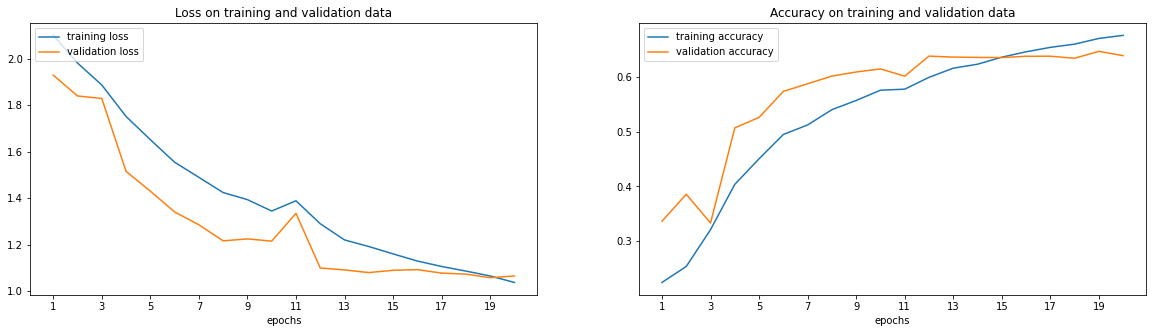

In [19]:
plot_history(history_mobilenet)

In [20]:
best_mobilenet_model = keras.models.load_model('best_mobilenet_model.keras')
test_mobilenet_loss, test_mobilenet_acc = best_mobilenet_model.evaluate(x_test_pr, y_test)
print(f'Accuracy on testing data with a transformed MobileNetV2 model: {test_mobilenet_acc:0.2%}')

313/313 [==============================] - 3s 7ms/step - loss: 1.0891 - accuracy: 0.6433
Accuracy on testing data with a transformed MobileNetV2 model: 64.33%


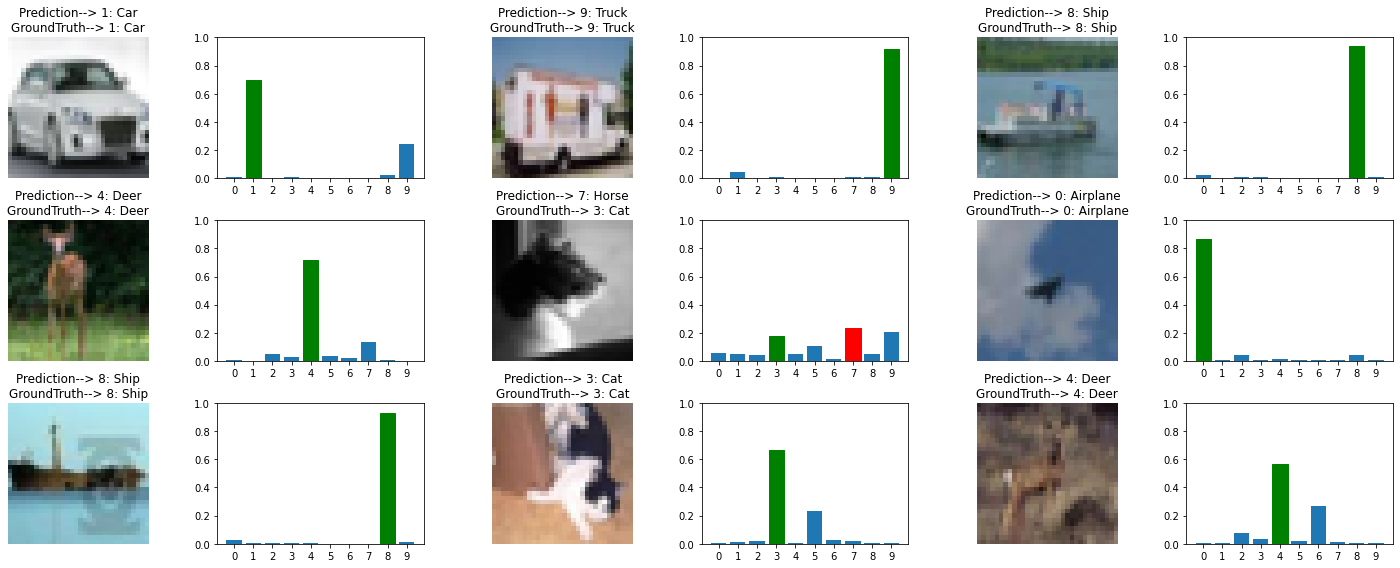

In [26]:
plot_prob_pred(best_mobilenet_model, x_test_pr)

# Conclusions <a id = "5"></a> 

Due to the low quality of the photos, the **optimal error rate** is assumed to be 90%.
The CNN model had many **avoidable biases**. This problem can be solved by increasing the model size or by changing the model architecture. Due to this, the pre-trained MobileNetV2 was used.
Accordingly, the change in the model architecture significantly reduced **avoidable bias**.To achieve a better result, you can increase the epochs or start training from the basic layers of the mobile model. Increasing the epochs or starting from the basics of the mobilenetv2 model will allow you to achieve a better result.
<br>

<p style="text-align:center;"><img src="https://miro.medium.com/max/1400/1*dPsfWuAvNJm29val0Uek9w.png" width="450"></p>

# Gradio <a id = "6"></a> 

In [22]:
def predict_with_mobilenetv2(inp):
    inp_pr = preprocess_input(inp[np.newaxis, ...])
    pred_prob = best_mobilenet_model.predict(inp_pr).flatten().tolist()
    return {index_to_name[i]: pred_prob[i] for i in range(10)}

In [ ]:
iface = gr.Interface(fn = predict_with_mobilenetv2,
                     inputs = gr.inputs.Image(shape = (32, 32)),
                     outputs = gr.outputs.Label(num_top_classes = 5),
                     live = True,
                     examples = [
                                 ['https://raw.githubusercontent.com/AlirezaHanifi/My-Journey-into-Deep-Learning/master/1-%20CIFAR-10%20Image%20classification%20using%20simple%20CNN%20and%20MobileNetV2/examples/airplane.jpg'],
                                 ['https://raw.githubusercontent.com/AlirezaHanifi/My-Journey-into-Deep-Learning/master/1-%20CIFAR-10%20Image%20classification%20using%20simple%20CNN%20and%20MobileNetV2/examples/automobile.jpg'],
                                 ['https://raw.githubusercontent.com/AlirezaHanifi/My-Journey-into-Deep-Learning/master/1-%20CIFAR-10%20Image%20classification%20using%20simple%20CNN%20and%20MobileNetV2/examples/bird.jpg'],
                                 ['https://raw.githubusercontent.com/AlirezaHanifi/My-Journey-into-Deep-Learning/master/1-%20CIFAR-10%20Image%20classification%20using%20simple%20CNN%20and%20MobileNetV2/examples/cat.jpg'],
                                 ['https://raw.githubusercontent.com/AlirezaHanifi/My-Journey-into-Deep-Learning/master/1-%20CIFAR-10%20Image%20classification%20using%20simple%20CNN%20and%20MobileNetV2/examples/deer.jpg'],
                                 ['https://raw.githubusercontent.com/AlirezaHanifi/My-Journey-into-Deep-Learning/master/1-%20CIFAR-10%20Image%20classification%20using%20simple%20CNN%20and%20MobileNetV2/examples/dog.jpg'],
                                 ['https://raw.githubusercontent.com/AlirezaHanifi/My-Journey-into-Deep-Learning/master/1-%20CIFAR-10%20Image%20classification%20using%20simple%20CNN%20and%20MobileNetV2/examples/frog.jpg'],
                                 ['https://raw.githubusercontent.com/AlirezaHanifi/My-Journey-into-Deep-Learning/master/1-%20CIFAR-10%20Image%20classification%20using%20simple%20CNN%20and%20MobileNetV2/examples/horse.jpg'],
                                 ['https://raw.githubusercontent.com/AlirezaHanifi/My-Journey-into-Deep-Learning/master/1-%20CIFAR-10%20Image%20classification%20using%20simple%20CNN%20and%20MobileNetV2/examples/ship.jpg'],
                                 ['https://raw.githubusercontent.com/AlirezaHanifi/My-Journey-into-Deep-Learning/master/1-%20CIFAR-10%20Image%20classification%20using%20simple%20CNN%20and%20MobileNetV2/examples/truck.jpg']
                                 ]
                    ).launch(share = True, debug = True)                  


# References <a id = "7"></a> 

- <a href = 'https://towardsdatascience.com/two-important-machine-learning-concepts-to-improve-every-model-62fd058916b'>Bias and Variance: Two Important Machine Learning Concepts to Improve Every Model</a>